In [1]:
from google.colab import drive
from tqdm.auto import tqdm
import pprint
import torch
import os

drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/____huggingface/Multi-Label_Toxic_comments")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
pprint = pprint.PrettyPrinter(indent=4).pprint
device, torch.cuda.get_device_name(0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(device(type='cuda'), 'Tesla T4')

In [2]:
%%capture
!pip install tokenizers
!pip install transformers
!pip install mlflow
!pip install -U torch

# Download Kaggle Dataset

Since we have to download the dataset from kaggle we can directly use their API which requires that the kaggle.json file (downloadble from the user settings) is in the right position. 

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile

!mkdir -p ~/.kaggle/ && cp kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

api = KaggleApi()
api.authenticate()

challenge = "jigsaw-toxic-comment-classification-challenge"
api.competition_download_file(challenge, "test.csv.zip", path="./")

with zipfile.ZipFile('test.csv.zip', 'r') as zip:
  zip.extractall('./data')
os.remove('test.csv.zip')

We can have a quick view on the dataset and looking at the distributions of the target variables.

In [30]:
import pandas as pd
import numpy as np

data_path = './data'

train_raw = pd.read_csv(f"{data_path}/train.csv")
train_raw.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0


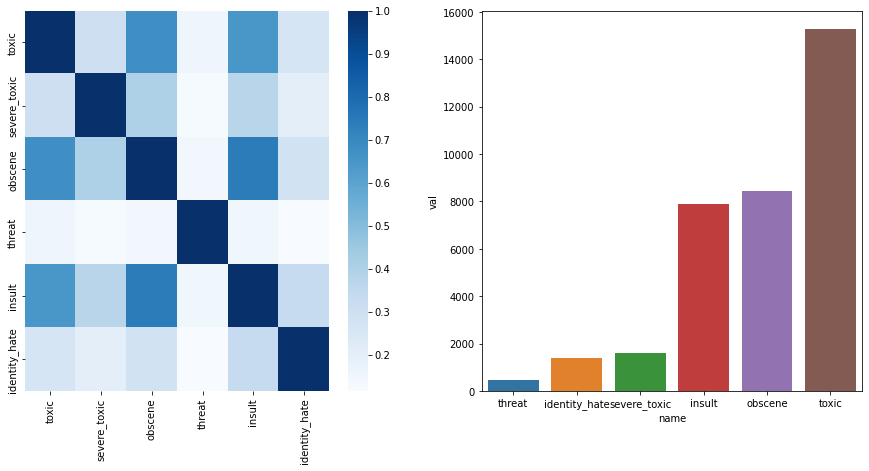

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt


tmp = pd.DataFrame(
                  {'toxic': train_raw.toxic.loc[train_raw.toxic == 1].sum(),
                  'severe_toxic': train_raw.severe_toxic.loc[train_raw.severe_toxic == 1].sum(),
                  'obscene': train_raw.obscene.loc[train_raw.obscene == 1].sum(),
                  'threat': train_raw.threat.loc[train_raw.threat == 1].sum(),
                  'insult': train_raw.insult.loc[train_raw.insult == 1].sum(),
                  'identity_hate': train_raw.identity_hate.loc[train_raw.identity_hate == 1].sum()}, index=[0]).T.reset_index()

tmp.rename(columns={"index":"name", 0:"val"}, inplace=True)
tmp.sort_values('val', inplace=True)

fig,axes = plt.subplots(1,2, figsize=(15,7))

sns.heatmap(train_raw.iloc[:, 2:].corr(), cmap='Blues', ax=axes[0])
sns.barplot(x='name', y="val", data=tmp)

plt.show()

# Data pre-process

Since we want to perform a multi-label classification we have to encode our target variable in a specific way. in particular it has to be a list with N integer each representing a particular class that we want to predict. 

In [31]:
targets = [
            "toxic",
            "severe_toxic",
            "obscene",
            "threat",
            "insult",
            "identity_hate"
            ]

agg_target = train_raw[targets].values
train_raw.drop(targets, axis=1, inplace=True)
train_raw.drop(['id'], axis=1, inplace=True)
train_raw['target'] = agg_target.tolist()

train_raw.head()

,comment_text,target
0,Explanation\nWhy the edits made under my usern...,"[0, 0, 0, 0, 0, 0]"
1,D'aww! He matches this background colour I'm s...,"[0, 0, 0, 0, 0, 0]"
2,"Hey man, I'm really not trying to edit war. It...","[0, 0, 0, 0, 0, 0]"
3,"""\nMore\nI can't make any real suggestions on ...","[0, 0, 0, 0, 0, 0]"
4,"You, sir, are my hero. Any chance you remember...","[0, 0, 0, 0, 0, 0]"


# Torch Dataset and DataLoader

We create now our actual dataset and dataloader using the torch classes.
we recall that torch class Dataset stores the samples and their corresponding labels, while DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

each dataset must have the __len__ properties and the __getitem__ properties well defined. in our case we decide to tokenize the sentence while are feeded to the model. Doing this basically when we iterate over the dataset the elements will be first cleaned up and then tokenized.

We cleaned up a little the text removing some punctuation. 

then we create the tokens as follow:

```py
        inputs = self._tokenizer.encode_plus(
            comment_text,
            # None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_token_type_ids=False,
        )
```

Where max_length we remember that for BERT and similar must be less than 512, the return_token_type_ids in our case is useless since it represent the number of the sentece (BERT was trained also to understand if two sentences could be attacched, in that case the first sentece had token_type_ids = 0 while the second = 1, since we are not reproducing this kind of training we just remove it). We allow truncation so in case there are some sentences that have more that max_length tokens they will be truncated and we specify the padding techniques, in this case to the maximum_length.

We also create a simple function that create the dataset and the dataloader according to the batch_size argument passed. 

In [32]:
from torch.utils.data import Dataset, DataLoader

class BertDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=512):
        self.data = dataframe
        self.comment_text = dataframe.comment_text
        self.targets = self.data.target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def pre_process_text(self,row):
      row = row.translate({44:32, 45:32, 34:32, 95:32, 46:32, 58:32})
      row = row.replace('\n',' ')
      row = row.lower()
      return row

    def __getitem__(self, index):
        comment_text = self.comment_text[index]
        comment_text = self.pre_process_text(comment_text)
        
        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding="max_length",
            return_token_type_ids=False,
        )

        return {
                'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
                'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
                'targets': torch.tensor(self.targets[index], dtype=torch.float)
                }


def create_train_test_torch(train_raw, tokenizer, BATCH_SIZE, TOKENIZER_MAX_LENGHT, train_size=0.8):
  train_dataset = train_raw.sample(frac=train_size, random_state=42)
  
  eval_dataset = train_raw.drop(train_dataset.index).reset_index(drop=True)
  train_dataset = train_dataset.reset_index(drop=True)

  training_set = BertDataset(train_dataset, tokenizer, TOKENIZER_MAX_LENGHT)
  eval_set = BertDataset(eval_dataset, tokenizer, TOKENIZER_MAX_LENGHT)

  train_loader = DataLoader(training_set, batch_size= BATCH_SIZE, shuffle=True)
  test_loader = DataLoader(eval_set, batch_size= BATCH_SIZE, shuffle=True)

  return train_loader, test_loader

# Token Type IDs

Some models’ purpose is to do sequence classification or question answering. These require two different sequences to be joined in a single “input_ids” entry, which usually is performed with the help of special tokens, such as the classifier ([CLS]) and separator ([SEP]) tokens. 


in our case all the phrases will marked as first since we do not want to do that operation.

# Create BERT model classifier

we create the BERT model as it is in BertForSequenceClassification specifyng the number of classes that we need, in this case 6. 

In [33]:
from torch.nn import (Dropout, Linear)
from transformers import (BertTokenizer, 
                          BertModel, 
                          BertConfig, 
                          PreTrainedModel)

# This allows you to use the built-in save and load mechanisms. 
# Instead of torch.save you can do model.save_pretrained("your-save-dir/) 
# 1. After that you can load the model with Model.from_pretrained("your-save-dir/").

class BERTClassifier(PreTrainedModel):
    def __init__(self, name='bert-model', config=BertConfig(), BERT_MODEL='bert-base-uncased'):
        super().__init__(config=config)

        self.bert = BertModel.from_pretrained(BERT_MODEL, config=config)
        self.dropout = Dropout(0.15)
        self.classifier = Linear(768, 6)
    
        self.name = name
    
    def forward(self, ids, mask):
        output_dict = self.bert(ids, attention_mask=mask, return_dict=True)

        # last_hidden_state (torch.FloatTensor of shape (batch_size, sequence_length, hidden_size)) — Sequence of hidden-states at the output of the last layer of the model.
        # pooler_output (torch.FloatTensor of shape (batch_size, hidden_size)) — Last layer hidden-state of the first token of the sequence (classification token) after further processing 
        # through the layers used for the auxiliary pretraining task. E.g. for BERT-family of models, this returns the classification token after processing through a linear layer and a tanh 
        # activation function. The linear layer weights are trained from the next sentence prediction (classification) objective during pretraining.

        output = self.dropout(output_dict['pooler_output'])
        output = self.classifier(output)
        return output

model = BERTClassifier()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We can control what we are doing performing this little example in  which we encode we extract an observation from the dataframe, we print out the ids (specyfing a max_len for the tokenizer very low) and we see how it looks after the decoding. We also try to predict the probabities of it with the model not trained (they are basically random number).

In [34]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train, test = create_train_test_torch(train_raw, tokenizer, 16, 15, 0.9)


for idx, val in enumerate(train):
  print(val['ids'][0])
  print(tokenizer.decode(val['ids'][0]))
  print(torch.sigmoid(model(ids=val['ids'], mask=val['mask'])[0]).tolist())
  break

tensor([  101,  2755,  2007,  1996,  8208,  1997,  2151, 28937,  2015,  4567,
          102,     0,     0,     0,     0])
[CLS] fact with the removal of any inferences drawn [SEP] [PAD] [PAD] [PAD] [PAD]
[0.5212186574935913, 0.5549576878547668, 0.5018728971481323, 0.48433735966682434, 0.4165497124195099, 0.5627778172492981]


# Trainer

We create also the trainer class that deal the training steps, the logging of all the metrics and the model.

In [35]:
from tqdm.notebook import tqdm, trange
from sklearn import metrics
import mlflow

class Trainer:
  def __init__(self, model, loss_fn, epochs, path, scheduler, optimizer, thresold=.5):
    self.model = model
    self.loss_fn = loss_fn
    self.scheduler = scheduler
    self.optimizer = optimizer
    self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
    self.model.to(self.device)
    self.thresold = thresold
    self.epochs = epochs
    self.path = path

  def training_loop(self, training_loader, testing_loader, **kwargs) -> None:
    with mlflow.start_run(run_name=kwargs['run_name']) as run:  
      for key, value in kwargs.items():
        mlflow.log_param(key, value)

      self.train(training_loader, testing_loader)
  
  def log_loss(self, loss, progress_bar_batch) -> None:
    mlflow.log_metric("train_loss", loss, step=self.overall_step)
    progress_bar_batch.set_postfix({"loss": loss, "step": self.overall_step})
    self.overall_step += 1

  def train(self, training_loader, testing_loader) -> None:
    self.overall_step = 0
    progress_bar_epoch = trange(self.epochs, leave=True, desc='Epoch')
    for epoch in progress_bar_epoch:
      self.model.train()
      progress_bar_batch = tqdm(enumerate(training_loader), leave=False, total=len(training_loader), desc='Training')
      for idx, data in progress_bar_batch:
        self.optimizer.zero_grad()

        ids = data['ids'].to(self.device, dtype=torch.long)
        mask = data['mask'].to(self.device, dtype=torch.long)
        targets = data['targets'].to(self.device, dtype=torch.float)

        outputs = self.model(ids, mask)

        loss = self.loss_fn(outputs, targets)
        loss.backward()

        self.optimizer.step()

        if (idx%250 == 0): self.log_loss(loss.item(), progress_bar_batch)

      _metrics = self.validation(testing_loader, epoch)
      progress_bar_epoch.set_postfix(_metrics)

      self.scheduler.step()
        

  def validation(self, testing_loader, epoch) -> dict:
    self.model.eval()
    eval_targets, eval_outputs = [],[]
    with torch.no_grad():
      progress_bar_test = tqdm(enumerate(testing_loader), leave=False, total=len(testing_loader), desc='Testing')

      for idx, data in progress_bar_test:
          ids = data['ids'].to(self.device, dtype = torch.long)
          mask = data['mask'].to(self.device, dtype = torch.long)
          targets = data['targets'].to(self.device, dtype = torch.float)

          outputs = self.model(ids, mask)

          eval_targets.extend(targets.cpu().detach().numpy().tolist())

          probabilities = torch.sigmoid(outputs)
          predicted = probabilities >= self.thresold
          eval_outputs.extend(predicted.cpu().detach().numpy().tolist())

    accuracy = metrics.accuracy_score(eval_targets, eval_outputs)
    f1_score_micro = metrics.f1_score(eval_targets, eval_outputs, average='micro')
    f1_score_macro = metrics.f1_score(eval_targets, eval_outputs, average='macro')

    mlflow.log_metric("f1_score_macro", f1_score_macro, step=epoch)
    mlflow.log_metric("f1_score_micro", f1_score_micro, step=epoch)
    mlflow.log_metric("accuracy", accuracy, step=epoch)

    torch.save(self.model, f"{self.path}{self.model.name}.pt")
    torch.save({"optimizer": self.optimizer.state_dict(), 
                "scheduler": self.scheduler.state_dict(), 
                "epoch": epoch}, f"{self.path}{self.model.name}/re_train_args.pt")
    
    mlflow.pytorch.log_model(self.model, self.model.name)

    return {"Epoch":epoch, "f1_score_micro":f1_score_micro, "f1_score_macro":f1_score_macro, "accuracy": accuracy}

In [9]:
def print_details(model, params):
  print("-"*150)
  print(model)
  print("-"*150)
  for layer in params['trainable_layers']:
    print(f"Layer to train --> {layer}")
  print("-"*150)
  pprint(params)
  print("-"*150)

In [10]:
train = True

if train:
  !databricks configure --host https://community.cloud.databricks.com/
  mlflow.set_tracking_uri('databricks')
  mlflow.set_experiment("/Users/gabriele.ghisleni01@gmail.com/BertMultiClass")

Username: gabriele.ghisleni01@gmail.com
Password: 
Repeat for confirmation: 


In [36]:
import warnings
warnings.filterwarnings('ignore') 

if train:
  PARAMS = {"epochs":3, "lr":1e-04, "batch_size":8, "model_name": 'bert_base', 'gamma':0.96,
            "tokenizer_max_lenght":400, 'trainable_layers':[], "run_name":'bert_base_1'}


  model_hub = "bert-base-uncased"
  
  tokenizer = AutoTokenizer.from_pretrained(model_hub)
  training_loader, testing_loader = create_train_test_torch(train_raw, tokenizer, PARAMS['batch_size'], PARAMS["tokenizer_max_lenght"], 0.9)
  PARAMS['train-test_size'] = (len(training_loader)* PARAMS['batch_size'], len(testing_loader)* PARAMS['batch_size'])

  # model = BERTClassifier(name=PARAMS['model_name'], BERT_MODEL=model_hub)
  model = torch.load("model/bert_base.pt")

  optimizer = torch.optim.Adam(params=model.parameters(), lr=PARAMS['lr'])
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=PARAMS['gamma'])
  loss_fn = torch.nn.BCEWithLogitsLoss()

  optimizer.load_state_dict(torch.load("model/re_train_args.pt")['optimizer'])
  scheduler.load_state_dict(torch.load("model/re_train_args.pt")['scheduler'])

  for name, param in model.named_parameters():
    if "bert" in name: param.requires_grad = False
    if param.requires_grad: PARAMS['trainable_layers'].append(name)

  print_details(model, PARAMS)

------------------------------------------------------------------------------------------------------------------------------------------------------
BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
   

In [ ]:
trainer = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler, epochs=PARAMS['epochs'],  path='./model/')
trainer.training_loop(training_loader, testing_loader, **PARAMS)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/17952 [00:00<?, ?it/s]